In [20]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.ticker as mtick
from matplotlib import pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, mutual_info_regression

In [21]:
pickle_off = open ("return_1d.pkl", "rb")
return_1d = pickle.load(pickle_off)
return_1d

,Nifty_50_1d_return,Dow_Jons_1d_return,SPX_500_1d_return,NASDAQ_1d_return,BRENT_1d_return,BOND_10Y_1d_return,Gold_1d_return,Inr_Usd_1d_return,Dollar_Index_1d_return,Bank_Nifty_1d_return,Nifty_IT_1d_return,Nifty_Auto_1d_return,Nifty_Metal_1d_return,Nifty_FMGC_1d_return,Nifty_Energy_1d_return,NIFTY_FIN_SERVICE_1d_return,Nifty_Infra_1d_return,Nifty_CMDT_1d_return,Nifty_Consumer_1d_return
Date,,,,,,,,,,,,,,,,,,,
08-09-11,-0.53,-1.42,-1.37,-1.26,-1.42,-1.81,-1.74,-1.00,-2.71,-0.70,8.26,0.42,-1.46,-0.27,-0.34,-1.00,-0.83,-0.81,-1.19
13-09-11,-0.95,-0.36,0.31,0.35,-0.30,1.97,-1.37,0.01,-2.73,-0.80,-1.27,1.72,0.03,-0.86,-1.16,0.42,-0.88,-0.26,0.88
14-09-11,-13.25,2.14,0.48,0.07,-2.42,-0.68,-1.19,-0.43,-0.88,-3.40,3.66,-0.71,-1.07,-91.91,3.21,-0.79,0.02,-1.14,-0.63
15-09-11,-0.13,0.31,0.28,-0.16,4.74,2.96,12.66,-0.67,6.38,0.40,-0.46,-5.15,8.29,-1.20,-0.03,-2.90,-2.51,5.99,-3.54
16-09-11,-0.87,-0.60,-0.67,-0.56,-2.03,-1.12,-1.77,-1.60,-1.58,-0.69,-1.44,-0.69,-0.91,3.86,-0.64,1.62,0.43,-0.60,-1.61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24-04-23,-299.38,1.97,-0.06,-3.73,0.90,-3.49,-1.35,-0.55,22.50,-4.43,0.03,-0.96,-1.33,-0.35,108.75,-7.56,-2.08,-1.79,3.18
25-04-23,-0.78,-6.18,-19.57,5.77,-2.81,1.43,-0.49,1.22,-2.09,-0.92,-1.14,-3.07,0.37,-0.60,7.12,-1.13,0.35,-0.27,0.05
26-04-23,0.71,-0.33,-0.76,-1.24,0.61,-1.26,-2.69,-1.70,-1.76,2.54,-3.85,5.08,-1.71,2.08,-1.11,-2.33,-0.39,-1.47,0.29


In [22]:
'''# Add lagged returns as features
return_1d['Bank_Nifty_1d_return'] = return_1d['Bank_Nifty_1d_return'].shift(1)
return_1d['Nifty_50_1d_return_lag1'] = return_1d['Nifty_50_1d_return'].shift(1)
return_1d = return_1d.dropna()
return_1d['return_squared'] = return_1d['Bank_Nifty_1d_return'] ** 2
return_1d['return_lag_interaction'] = return_1d['Bank_Nifty_1d_return'] * return_1d['Nifty_50_1d_return_lag1']
'''# Detect and remove outliers using IQR
q1 = return_1d['Bank_Nifty_1d_return'].quantile(0.25)
q3 = return_1d['Bank_Nifty_1d_return'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5*iqr
upper_bound = q3 + 1.5*iqr
return_1d = return_1d[(return_1d['Bank_Nifty_1d_return'] >= lower_bound) & (return_1d['Bank_Nifty_1d_return'] <= upper_bound)]
np.random.seed(42)

In [23]:
# Display the cleaned data
print("Cleaned data:")
print(return_1d.head())

Cleaned data:
          Nifty_50_1d_return  Dow_Jons_1d_return  SPX_500_1d_return  \
Date                                                                  
08-09-11               -0.53               -1.42              -1.37   
13-09-11               -0.95               -0.36               0.31   
14-09-11              -13.25                2.14               0.48   
15-09-11               -0.13                0.31               0.28   
16-09-11               -0.87               -0.60              -0.67   

          NASDAQ_1d_return  BRENT_1d_return  BOND_10Y_1d_return  \
Date                                                              
08-09-11             -1.26            -1.42               -1.81   
13-09-11              0.35            -0.30                1.97   
14-09-11              0.07            -2.42               -0.68   
15-09-11             -0.16             4.74                2.96   
16-09-11             -0.56            -2.03               -1.12   

          Gold_1d_

In [24]:
# Display the statistics of the cleaned data
print("Statistics of the cleaned data:")
print(return_1d.describe())

Statistics of the cleaned data:
       Nifty_50_1d_return  Dow_Jons_1d_return  SPX_500_1d_return  \
count         1760.000000         1760.000000        1760.000000   
mean            -1.120313           -2.029335           0.670472   
std             16.335171          134.762456          43.474807   
min           -448.890000        -3606.010000        -356.660000   
25%             -1.665000           -1.900000          -2.000000   
50%             -0.890000           -1.010000          -1.030000   
75%             -0.100000           -0.147500          -0.220000   
max            200.540000         3322.270000        1128.740000   

       NASDAQ_1d_return  BRENT_1d_return  BOND_10Y_1d_return  Gold_1d_return  \
count       1760.000000      1760.000000         1760.000000     1760.000000   
mean          -2.240778        -2.136369           -1.034756       -1.038562   
std           63.212877        23.032456            2.320302        9.733995   
min        -1517.720000      -426.1

In [25]:
# Correlation analysis
corr_matrix_1d = return_1d.corr()
nifty_corr_1d = pd.DataFrame(return_1d.corr()['Bank_Nifty_1d_return'].sort_values())
nifty_corr_1d

,Bank_Nifty_1d_return
Gold_1d_return,-0.038525
SPX_500_1d_return,-0.034283
BOND_10Y_1d_return,-0.032728
Inr_Usd_1d_return,0.007832
Nifty_Energy_1d_return,0.009101
Dollar_Index_1d_return,0.009888
Dow_Jons_1d_return,0.010959
Nifty_FMGC_1d_return,0.021137
Nifty_Auto_1d_return,0.025703
BRENT_1d_return,0.028054


<Axes: >

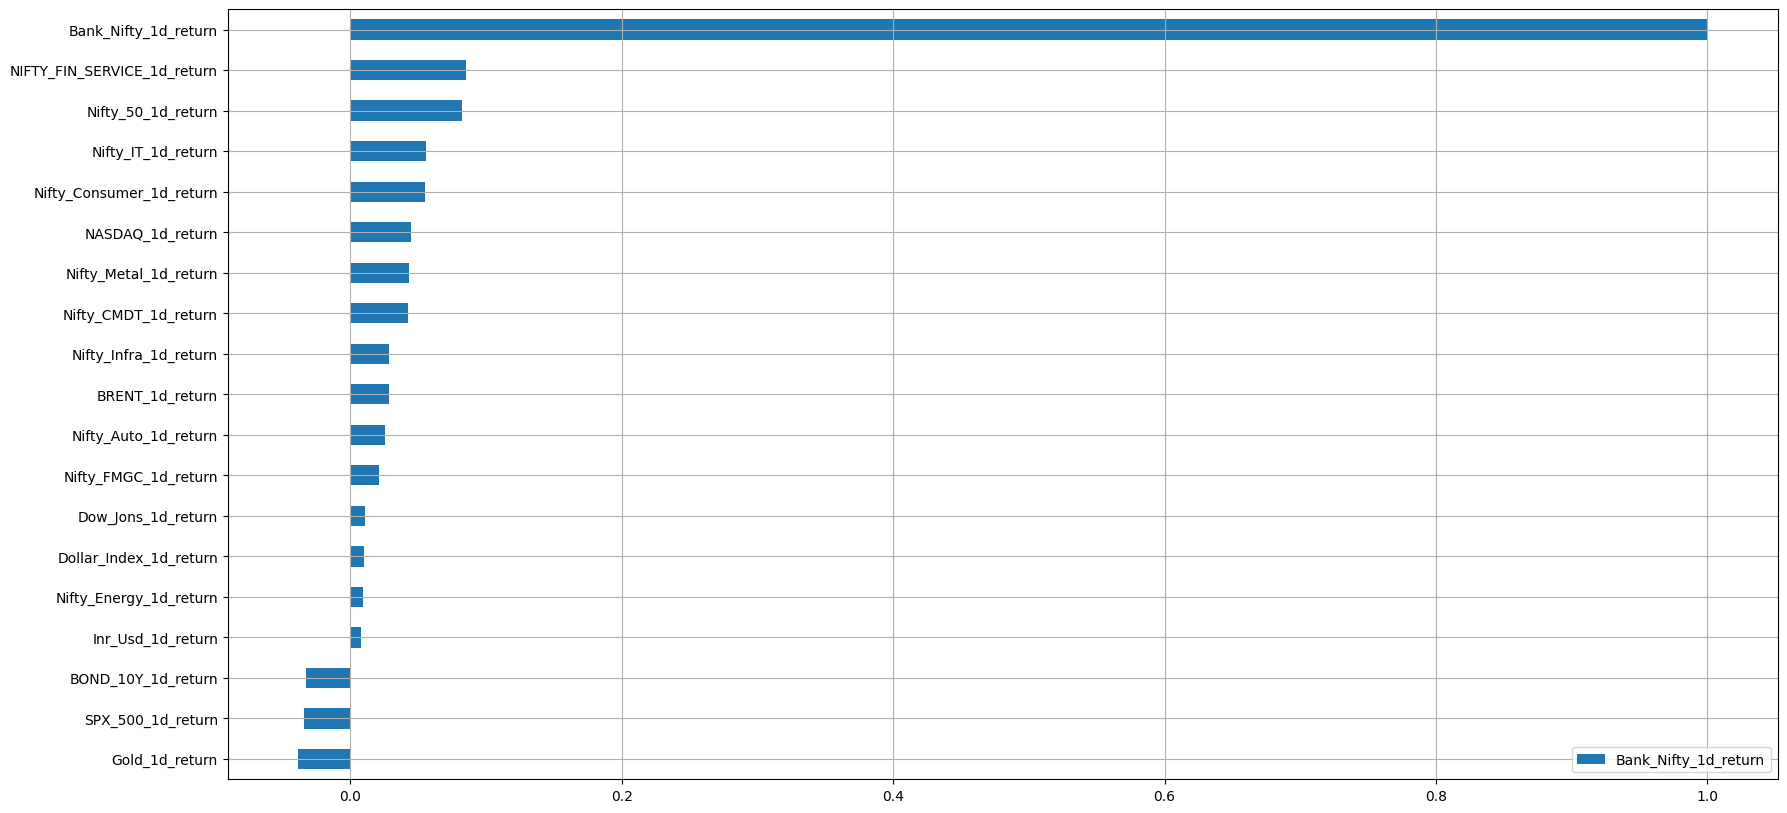

In [26]:
filter = np.abs(nifty_corr_1d)  # this creates a float64 array
mask = filter >= -1  # this creates a boolean mask based on the condition
nifty_corr_1d[mask].plot.barh(figsize=(20,10), grid=True)  # use the boolean mask to index the DataFrame

In [27]:
# Feature selection using mutual information
selector = SelectKBest(score_func=mutual_info_regression, k=6)
X = return_1d.drop(columns='Bank_Nifty_1d_return')
y = return_1d['Bank_Nifty_1d_return']
X_new = selector.fit_transform(X, y)
print('Selected features:', X.columns[selector.get_support()])

Selected features: Index(['Nifty_50_1d_return', 'Nifty_Metal_1d_return',
       'NIFTY_FIN_SERVICE_1d_return', 'Nifty_Infra_1d_return',
       'Nifty_CMDT_1d_return', 'Nifty_Consumer_1d_return'],
      dtype='object')


In [28]:
# Feature Scaling
scaler = StandardScaler()
X = return_1d.drop(columns='Bank_Nifty_1d_return')
y = return_1d['Bank_Nifty_1d_return']
X = scaler.fit_transform(X_new)
y = y.astype('float32')
print(X[-5:])
print(y[-5:])

[[-1.82639319e+01 -3.88727677e-02 -1.71837704e-01 -4.20763754e-02
  -5.12670243e-02  1.17381315e-01]
 [ 2.08390359e-02  1.94286870e-02 -3.73498327e-02  9.79446661e-02
  -2.84263544e-02 -1.47487877e-02]
 [ 1.12079186e-01 -5.19048575e-02 -6.24486578e-02  5.53045136e-02
  -4.64584622e-02 -4.61740600e-03]
 [ 1.46983135e-01 -8.34562330e-02  1.30569745e-02  1.14078778e-01
  -1.01756926e-01 -1.64373513e-02]
 [ 9.73827856e-02  1.08549436e-02 -2.01989688e-02  1.55566494e-01
  -9.34237359e-03  3.75966845e-02]]
Date
24-04-23   -4.43
25-04-23   -0.92
26-04-23    2.54
27-04-23    0.13
28-04-23    0.36
Name: Bank_Nifty_1d_return, dtype: float32


Data Cleaning And Transformation Completed

Model Building for Features Importance

In [29]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
# Define regression models
dtr = DecisionTreeRegressor(max_depth=5)
rfr = RandomForestRegressor(n_estimators=50, random_state=2)
etr = ExtraTreesRegressor(n_estimators=50, random_state=2)
gbr = GradientBoostingRegressor(n_estimators=50, random_state=2)
xgbr = XGBRegressor(n_estimators=50, random_state=2)

In [31]:
regressors = {
    'DTR': dtr,
    'RFR': rfr,
    'ETR': etr,
    'GBR': gbr,
    'XGBR': xgbr
}

In [32]:
def train_regressor(regressor, X_train, y_train, X_test, y_test):
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mse, r2

In [33]:
mse_scores = []
r2_scores = []
for name, regressor in regressors.items():
    current_mse, current_r2 = train_regressor(regressor, X_train, y_train, X_test, y_test)
    print(f"For {name}:")
    print(f"MSE: {current_mse:.4f}")
    print(f"R2: {current_r2:.4f}\n")
    mse_scores.append(current_mse)
    r2_scores.append(current_r2)

For DTR:
MSE: 1.0578
R2: 0.3811

For RFR:
MSE: 1.0534
R2: 0.3837

For ETR:
MSE: 1.0701
R2: 0.3739

For GBR:
MSE: 0.9358
R2: 0.4526

For XGBR:
MSE: 1.2719
R2: 0.2559



In [34]:
scaler = StandardScaler()
# Find the index of the model with the lowest MSE score
best_model_index = np.argmin(mse_scores)
# Get the name of the best model
best_model_name = list(regressors.keys())[best_model_index]
# Print the name of the best model
print(f"The best model is {best_model_name} with an MSE of {mse_scores[best_model_index]:.4f}.")
# Train the best model on the full dataset
best_model = regressors[best_model_name]
best_model.fit(scaler.fit_transform(X), y)

The best model is GBR with an MSE of 0.9358.


GradientBoostingRegressor(n_estimators=50, random_state=2)

The best model is XGBR with an MSE of 0.0684.

In [35]:
y_pred = gbr.predict(X_test)
df_1d = pd.DataFrame({'Actual': y_test, 'Predicted':y_pred})
df_1d

,Actual,Predicted
Date,,
23-09-19,-0.34,-0.191071
28-02-19,-0.94,-0.703053
28-11-22,-1.40,-0.531224
08-03-22,-1.20,-1.242109
24-10-13,-0.70,-0.099338
...,...,...
19-09-14,-1.01,-0.859235
10-04-19,-2.15,-2.707603
11-03-22,-0.90,-0.840375


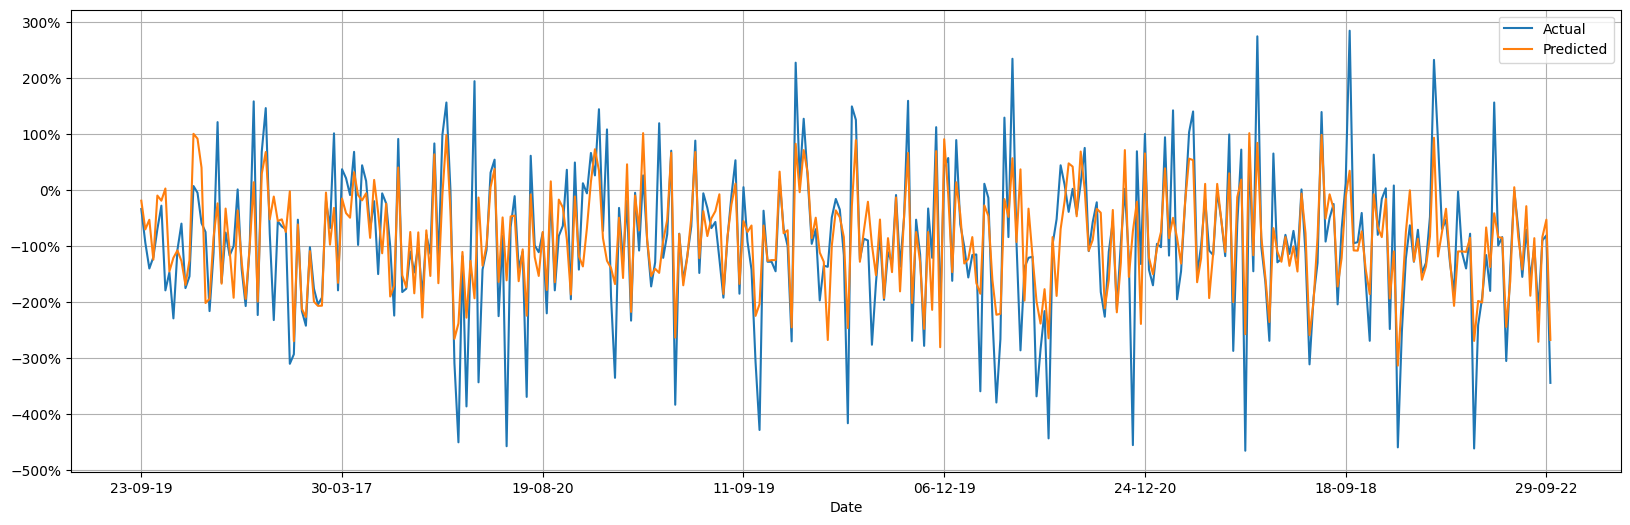

In [36]:
ax = df_1d.plot(figsize=(20,6), grid=True)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))

C:\Users\Harsh\AppData\Local\Temp\ipykernel_18592\3094767840.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_test-y_pred)


<Axes: xlabel='Bank_Nifty_1d_return', ylabel='Density'>

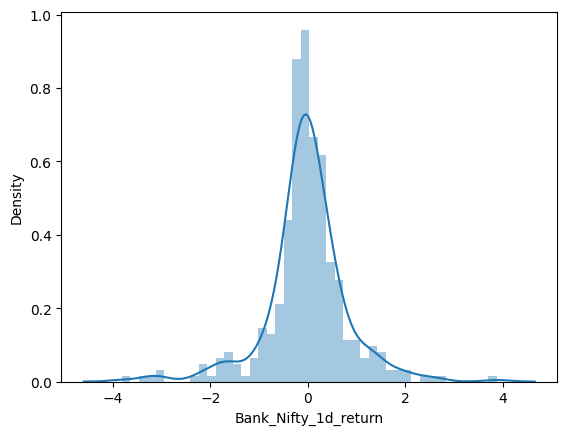

In [37]:
sns.distplot(y_test-y_pred)

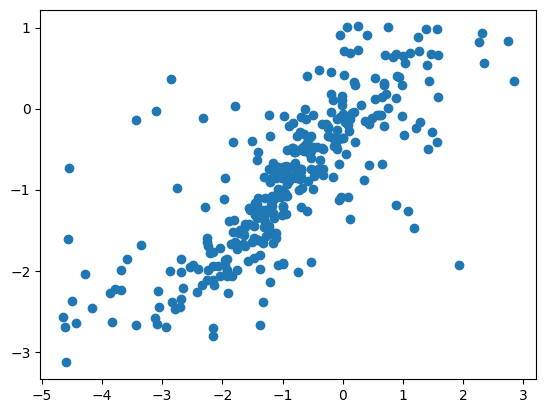

In [38]:
plt.scatter(y_test,y_pred)
